In [0]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set the drive/path
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision')

In [0]:
# Load dataset
img_array = np.load('images.npy',allow_pickle=True)

In [0]:
print('number of images in the given dataset is: ',img_array.shape[0])

number of images in the given dataset is:  409


In [0]:
# Checking to see for shape other than (width, Height, 3)
for i in range(0,img_array.shape[0]):
  try:
    if img_array[i][0].shape[2]>3:
      print(i,img_array[i][0].shape)
  except:
    print(i,img_array[i][0].shape)

1 (697, 1280, 4)
3 (291, 600, 4)
41 (340, 516, 4)
49 (600, 800, 4)
64 (312, 750, 4)
140 (330, 538, 4)
151 (496, 860, 4)
247 (379, 505, 4)
263 (400, 770, 4)
272 (350, 650)
337 (267, 740, 4)
347 (281, 600, 4)


We can observe that there are few more then 3 channels images and 1 channel image, that needs to be handled for building the model

**Create Features(images) and labels(mask) using that data.**


Image index number:  225


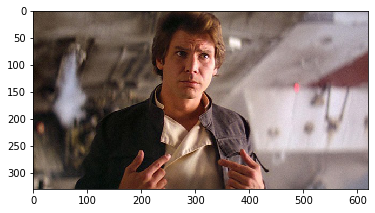

In [0]:
#Randomly viewing the images
img_num=np.random.randint(0,img_array.shape[0])
plt.imshow(img_array[img_num][0])
print('Image index number: ',img_num)

In [0]:
#Checking for the annotation details
img_array[img_num][0]

array([[[ 92,  76,  60],
        [ 80,  64,  48],
        [ 86,  70,  54],
        ...,
        [165, 154, 168],
        [164, 153, 167],
        [164, 153, 167]],

       [[ 85,  69,  53],
        [ 79,  63,  47],
        [ 83,  67,  51],
        ...,
        [169, 158, 172],
        [169, 158, 172],
        [168, 157, 171]],

       [[ 83,  67,  51],
        [ 83,  67,  51],
        [ 83,  67,  51],
        ...,
        [169, 161, 174],
        [168, 160, 173],
        [167, 159, 172]],

       ...,

       [[167, 150, 132],
        [160, 144, 129],
        [156, 142, 129],
        ...,
        [125, 125, 137],
        [126, 126, 138],
        [126, 126, 138]],

       [[160, 143, 127],
        [155, 139, 124],
        [150, 136, 125],
        ...,
        [132, 132, 144],
        [125, 125, 137],
        [123, 123, 135]],

       [[157, 140, 124],
        [154, 138, 123],
        [151, 137, 126],
        ...,
        [131, 130, 144],
        [121, 120, 134],
        [116, 115, 129]]

In [0]:
Data_set=[]
IMAGE_SIZE_Width=128
IMAGE_SIZE_Height=128
Data_set=[]
for j in range(0,img_array.shape[0]):
  image_name='image_'+ str(j+1)
  for i in img_array[j][1]:
    ori_Height=i['imageHeight']
    Ori_Width=i['imageWidth']
    label=i['label'][0]
    x1_ratio=i['points'][0]['x']
    x2_ratio=i['points'][1]['x']
    y1_ratio=i['points'][0]['y']
    y2_ratio=i['points'][1]['y']
    x1_ori=int((i['points'][0]['x'])*Ori_Width)
    x2_ori=int((i['points'][1]['x'])*Ori_Width)
    y1_ori=int((i['points'][0]['y'])*ori_Height)
    y2_ori=int((i['points'][1]['y'])*ori_Height)
    x_min=int((i['points'][0]['x'])*IMAGE_SIZE_Width)
    x_max=int((i['points'][1]['x'])*IMAGE_SIZE_Width)
    y_min=int((i['points'][0]['y'])*IMAGE_SIZE_Height)
    y_max=int((i['points'][1]['y'])*IMAGE_SIZE_Height)
    Data_set.append([image_name,ori_Height,Ori_Width,label,x1_ratio,x2_ratio,y1_ratio,y2_ratio,x1_ori,x2_ori,y1_ori,y2_ori,x_min,y_min,x_max,y_max])


In [0]:
df=pd.DataFrame(Data_set,columns=['filename','ori_Height','Ori_Width','class','x1_ratio','x2_ratio','y1_ratio','y2_ratio','x1_ori','x2_ori','y1_ori','y2_ori','x_min','y_min','x_max','y_max'])

df.head()

,filename,ori_Height,Ori_Width,class,x1_ratio,x2_ratio,y1_ratio,y2_ratio,x1_ori,x2_ori,y1_ori,y2_ori,x_min,y_min,x_max,y_max
0,image_1,333,650,Face,0.086154,0.172308,0.306306,0.453453,56,112,102,151,11,39,22,58
1,image_1,333,650,Face,0.583077,0.658462,0.291291,0.468468,379,428,97,156,74,37,84,59
2,image_2,697,1280,Face,0.705309,0.769231,0.232604,0.361829,902,984,162,252,90,29,98,46
3,image_3,240,460,Face,0.469565,0.606522,0.050000,0.333333,216,279,12,80,60,6,77,42
4,image_3,240,460,Face,0.628261,0.745652,0.008333,0.308333,289,343,2,74,80,1,95,39


In [0]:
len(df['filename'].unique())

409

In [0]:
df.tail()

,filename,ori_Height,Ori_Width,class,x1_ratio,x2_ratio,y1_ratio,y2_ratio,x1_ori,x2_ori,y1_ori,y2_ori,x_min,y_min,x_max,y_max
1127,image_409,493,656,Face,0.250000,0.285061,0.247465,0.304260,164,186,122,150,32,31,36,38
1128,image_409,493,656,Face,0.484756,0.527439,0.233266,0.322515,318,346,115,159,62,29,67,41
1129,image_409,493,656,Face,0.592988,0.620427,0.316430,0.359026,389,407,156,177,75,40,79,45
1130,image_409,493,656,Face,0.772866,0.801829,0.413793,0.458418,507,526,204,226,98,52,102,58
1131,image_409,493,656,Face,0.803354,0.850610,0.515213,0.626775,527,558,253,309,102,65,108,80


In [0]:
print('Number of Classes in the dataset: ',len(df['class'].unique()))

Number of Classes in the dataset:  1


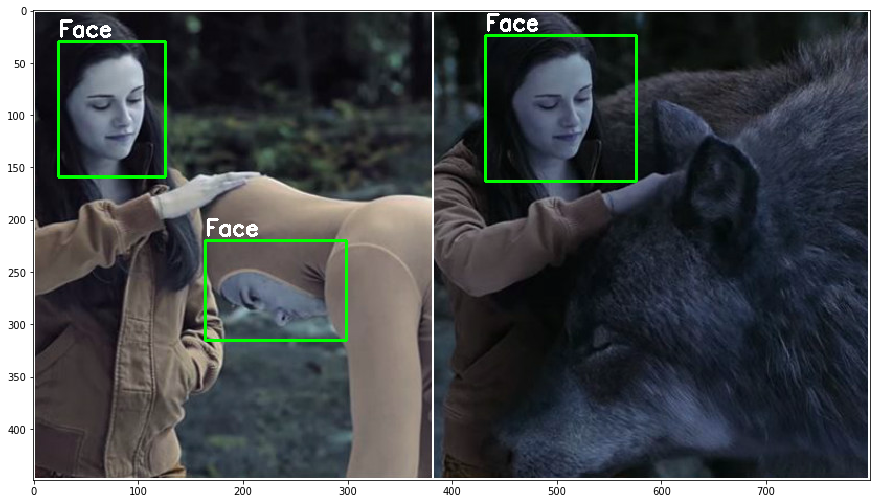

In [0]:
#Pickup a random image number
img_num = np.random.randint(0, df.shape[0])
#img_num=5

#Read the image
img_file = df.loc[img_num,'filename']
img_loc=int(df.loc[img_num,'filename'].split('_')[1])-1
img = img_array[img_loc][0]

#Find all rows which have same file name
rows_with_file = df[df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
for i in rows_with_file:

    #Get bounding box
    xmin, ymin, xmax, ymax = df.loc[i, ['x1_ori', 'y1_ori', 'x2_ori', 'y2_ori']]
    #Get Label
    label = df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()

In [0]:
#Checking for the annotation details
img_array[12][1]

[{'imageHeight': 3423,
  'imageWidth': 5000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.027709861450692746, 'y': 0.10357142857142858},
   {'x': 0.17277913610431947, 'y': 0.38095238095238093}]},
 {'imageHeight': 3423,
  'imageWidth': 5000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.20048899755501223, 'y': 0.22023809523809523},
   {'x': 0.3154034229828851, 'y': 0.4845238095238095}]},
 {'imageHeight': 3423,
  'imageWidth': 5000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.530562347188264, 'y': 0.11666666666666667},
   {'x': 0.6674816625916871, 'y': 0.40595238095238095}]},
 {'imageHeight': 3423,
  'imageWidth': 5000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6764466177669112, 'y': 0.2904761904761905},
   {'x': 0.7685411572942136, 'y': 0.49166666666666664}]},
 {'imageHeight': 3423,
  'imageWidth': 5000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.778321108394458, 'y': 0.1773809523809524},
   {'x': 0.9176854115729421, 'y': 

In [0]:
df[df['filename']=='image_12']

,filename,ori_Height,Ori_Width,class,x1_ratio,x2_ratio,y1_ratio,y2_ratio,x1_ori,x2_ori,y1_ori,y2_ori,x_min,y_min,x_max,y_max
25,image_12,960,648,Face,0.046296,0.203704,0.163542,0.298958,30,132,157,287,5,20,26,38
26,image_12,960,648,Face,0.319444,0.557099,0.137500,0.295833,206,361,132,284,40,17,71,37
27,image_12,960,648,Face,0.564815,0.714506,0.187500,0.305208,365,462,180,293,72,24,91,39
28,image_12,960,648,Face,0.716049,0.833333,0.209375,0.306250,464,540,201,294,91,26,106,39
29,image_12,960,648,Face,0.822531,0.942901,0.231250,0.317708,533,611,222,305,105,29,120,40


In [0]:
from keras.applications.mobilenet import preprocess_input
IMAGE_HEIGHT=128
IMAGE_WIDTH=128

#masks=np.zeros((int(img_array.shape[0]),IMAGE_HEIGHT,IMAGE_WIDTH))
masks=np.zeros((int(img_array.shape[0]), 4))
X_train=np.zeros((int(img_array.shape[0]),IMAGE_HEIGHT,IMAGE_WIDTH,3))
for index in range(img_array.shape[0]):
  img=img_array[index][0]
  img=cv2.resize(img, dsize=(IMAGE_HEIGHT,IMAGE_WIDTH),interpolation=cv2.INTER_CUBIC)
  try:
    img=img[:,:,:3]
  except:
    continue
  X_train[index]=preprocess_input(np.array(img,dtype=np.float32))
  masks[index,0] = x1_ori * IMAGE_WIDTH / Ori_Width
  masks[index,1] = y1_ori * IMAGE_HEIGHT / ori_Height
  masks[index,2] = x2_ori * IMAGE_WIDTH / Ori_Width
  masks[index,3] = y2_ori * IMAGE_HEIGHT / ori_Height

Using TensorFlow backend.


In [0]:
display(X_train.shape, masks.shape)

(409, 128, 128, 3)

(409, 4)

In [0]:
from PIL import Image
from keras_applications import mobilenet
from keras.applications.mobilenet import preprocess_input
from keras.backend import epsilon
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Reshape

Defining a custum loss function IOU which calculates intersction over UnionLoad the dataset given in form .npy format.
Load the dataset given in form .npy format.
Load the dataset given in form .npy format.
LoadLLLLLLLoadLoad the dataset given in form .npy format.
Load the dataset given in form .npy format.


In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

**Load the pre-trained model and weights**

In [0]:
from keras.applications.mobilenet import MobileNet
IMAGE_SIZE=128
IMG_SHAPE=(IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = MobileNet(input_shape=IMG_SHAPE,include_top=False,alpha=1.0)

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [0]:
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)-6

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32) 

In [0]:
X=base_model.layers[fine_tune_at].output
X=Conv2D(4,kernel_size=4)(X)
X=Reshape((4,))(X)

In [0]:
base_model=Model(inputs=base_model.input, output=X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  """Entry point for launching an IPython kernel.


In [0]:
import tensorflow as tf
base_model.compile(optimizer='adam',loss='mse',metrics=[IoU])


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
base_model.fit(X_train,masks,epochs=30,batch_size=32,verbose=1)



Epoch 1/30
409/409 [==============================] - 13s 31ms/step - loss: 2197.2454 - IoU: 0.1991
Epoch 2/30
409/409 [==============================] - 12s 29ms/step - loss: 394.2900 - IoU: 0.3623
Epoch 3/30
409/409 [==============================] - 12s 29ms/step - loss: 137.9866 - IoU: 0.5875
Epoch 4/30
409/409 [==============================] - 12s 28ms/step - loss: 62.5641 - IoU: 0.7127
Epoch 5/30
409/409 [==============================] - 12s 29ms/step - loss: 35.8743 - IoU: 0.7870
Epoch 6/30
409/409 [==============================] - 12s 28ms/step - loss: 28.4282 - IoU: 0.8124
Epoch 7/30
409/409 [==============================] - 12s 29ms/step - loss: 24.4143 - IoU: 0.8259
Epoch 8/30
409/409 [==============================] - 12s 28ms/step - loss: 22.2958 - IoU: 0.8360
Epoch 9/30
409/409 [==============================] - 12s 28ms/step - loss: 21.2050 - IoU: 0.8436
Epoch 10/30
409/409 [==============================] - 12s 29ms/step - loss: 17.8288 - IoU: 0.8554
Epoch 11/30
4